# 앙상블 및 스태킹 소개

이 캐글 노트북은 스태킹으로 알려진 앙상블 기법을 소개하고자 합니다.

앙상블 기법은 좀 덜 떨어지는 여러 대의 분류기가 학습 데이터를 학습 및 예측하여 나온 예측 결과를 다수결로 결정하는 방식과 동일한 분류기

를 사용하지만 각각의 학습 데이터를 샘플링을 달리하여 예측한 결과를 평균값으로 결정하는 방식이 있다.

스태킹기법은 각각의 분류기가 학습 후 예측한 결과를 볏짚 쌓듯이 차곡차곡 쌓아서 이를 다시 최종 메타 분류기가 다시 한번 학습 및 예측하는 기법.

해당 노트북은 [Stacking Starter][1]: by Faron  , [arthurtok][2] : by arthurtok 에 의해 쓰여진 캐글 노트북을 참고했습니다.

또한 최근의 [Introduction to Ensembling/Stacking in Python][3] 을 바탕으로 작성된 캐글임을 밝힙니다. 

피처엔지니어링에 대한 좋은 캐글은 [Titanic Best Working Classfier][4] 이 글을 참고하셔도 좋습니다.

"책을 읽는다는 것은 단순히 활자를 읽는다는 것이 아니라 , 그 시대를 읽는것이다"

  [1]: https://www.kaggle.com/mmueller/allstate-claims-severity/stacking-starter/run/390867
  [2]: https://www.kaggle.com/arthurtok/titanic/simple-stacking-with-xgboost-0-808
  [3]: https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python
  [4]: https://www.kaggle.com/sinakhorami/titanic/titanic-best-working-classifier

# Load library

In [1]:
import pandas as pd
import numpy as np
import sklearn
import re
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# 스태킹을 위해 5개의 ML모델을 사용
from sklearn.ensemble import (RandomForestClassifier,AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.cross_validation import KFold

# target directory for submission file
target_dir = '/kaggle/working/'

In [2]:
# plotly를 이용한 시각화
import plotly.offline as py
py.init_notebook_mode(connected=True)  # 캐글 및 코랩에서 사용가능하도록 셋업

import plotly.graph_objs as go
import plotly.tools as tls

# Feature Exploration, Engineering and Cleaning 

범주형 피처에 대해서 숫자형으로 인코딩, 피처 엔지니어링, EDA및 데이터 정제 진행

In [3]:
%cd ../input/titanic

/kaggle/input/titanic


In [4]:
def load_dataset():
    """
    데이터셋 로드
    """
    train = pd.read_csv("train.csv")
    test  = pd.read_csv("test.csv")
    
    PassengerId = test["PassengerId"]
    
    display(train.head(n=2), "\n", train.shape, test.shape)
    display(train.info())
    display(test.info())
    
    full_data = [train, test]
    
    return train, test, PassengerId, full_data

# 데이터셋로드 
train, test, PassengerId, full_data = load_dataset()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


'\n'

(891, 12)

(418, 11)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


None

범주형 변수(categorical variables)에서 인사이트를 찾아 새로운 파생변수를 생성하는 것이 피처 엔지니어링이라고 할 수 있다.

**피처 엔지니어링**

피처 엔지니어링에 대해서 아래 케글의 노트북을 참고하시면 좋을 것 같습니다.

[Titanic Best Working Classfier][1] : by Sina

  [1]: https://www.kaggle.com/sinakhorami/titanic/titanic-best-working-classifier

In [5]:
# Age피처를 5개의 범주형 데이터로 나눈 결과르 빈도수 확인
pd.cut(train['Age'], 5).value_counts()

(16.336, 32.252]    346
(32.252, 48.168]    188
(0.34, 16.336]      100
(48.168, 64.084]     69
(64.084, 80.0]       11
Name: Age, dtype: int64

In [6]:
# Fare피처를 4개의 범주형 데이터로 나눈 결과를 빈도수 확인
pd.cut(train['Fare'], 4).value_counts()

(-0.512, 128.082]     853
(128.082, 256.165]     29
(256.165, 384.247]      6
(384.247, 512.329]      3
Name: Fare, dtype: int64

In [7]:
full_data = [train, test]
train["Name_length"] = train["Name"].apply(len)
test["Name_length"] = test["Name"].apply(len)

# Cabin owns?
train["Has_Cabin"] = train["Cabin"].apply(lambda x: 0 if type(x) ==float else 1)
test["Has_Cabin"] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)


# New feature - 10 FamilySize
for dataset in full_data:
    dataset["FamilySize"] = dataset["Parch"] + dataset["SibSp"] + 1

# New Feature derived from FamilySize feature.
for dataset in full_data:
    dataset["IsAlone"] = 0
    dataset.loc[dataset["FamilySize"] ==1, "IsAlone"] = 1
    
# Removed null value from Embarked feature
for dataset in full_data:
    dataset["Embarked"] = dataset["Embarked"].fillna("S")
    
# Remove null value from Fare feature and create a new feature  - Fare_Band
for dataset in full_data:
    dataset["Fare"] = dataset["Fare"].fillna(train["Fare"].median())
    
train["CategoricalFare"] = pd.cut(train["Fare"], 4)

# Create a new feature CategoricalAge
# fill NaN value for Age feature into random value
for dataset in full_data:
    avg_age = dataset["Age"].mean()
    std_age = dataset["Age"].std()
    age_null_count = dataset["Age"].isnull().sum()
    age_null_random_list = np.random.randint(avg_age - std_age, avg_age + std_age, age_null_count)
    dataset["Age"][np.isnan(dataset["Age"])] = age_null_random_list
    dataset["Age"] = dataset["Age"].astype(int)
    
train["CategoricalAge"] = pd.cut(train["Age"], 5)  # Age피처의 값을 5개의 구간으로 분할

# Title피처에 대한 처리 
def get_title(name):
    """
    승선자의 이름을 인자로 존칭을 리턴
    """
    title = None
    title_search = re.search("([a-zA-Z]+)\.", name)
    if title_search:
        title = title_search.group(1)
    return title

for dataset in full_data:
    dataset["Title"] = dataset["Name"].apply(get_title)
    
for dataset in full_data:
    title_list = dataset["Title"].value_counts().index.tolist()
    # ['Mr','Miss','Mrs','Master',     'Dr',  'Rev',  'Major','Col',  'Mlle', 'Lady','Countess','Ms', 'Don', 'Mme', 'Jonkheer','Sir','Capt']
    dataset["Title"] = dataset["Title"].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset["Title"] = dataset["Title"].replace("Mlle", "Miss")
    dataset["Title"] = dataset["Title"].replace("Ms", "Miss")
    dataset["Title"] = dataset["Title"].replace("Mme", "Mrs")

for dataset in full_data:
    dataset["Sex"] = dataset["Sex"].map({"female": 0, "male":1})
    
    mapping_titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset["Title"] = dataset["Title"].map(mapping_titles)
    dataset["Title"] = dataset["Title"].fillna(0)
    
    # Embarked mapping
    dataset["Embarked"] = dataset["Embarked"].map({"S": 0, "C": 1, "Q": 2}).astype(int)
    
    # Age mapping
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4    
    
    # Fare mapping
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

In [8]:
# feature drop
drop_features = ["PassengerId", "Name", "Ticket", "Cabin", "SibSp"]
train = train.drop(drop_features, axis = 1)
train = train.drop(["CategoricalFare", "CategoricalAge"], axis = 1)
test  = test.drop(drop_features,  axis = 1)

## 시각화 

**Pearson Correlation Heatmap**

피처간의 상관관계를 한번 보도록 하자

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
Survived       891 non-null int64
Pclass         891 non-null int64
Sex            891 non-null int64
Age            891 non-null int64
Parch          891 non-null int64
Fare           891 non-null int64
Embarked       891 non-null int64
Name_length    891 non-null int64
Has_Cabin      891 non-null int64
FamilySize     891 non-null int64
IsAlone        891 non-null int64
Title          891 non-null int64
dtypes: int64(12)
memory usage: 83.6 KB


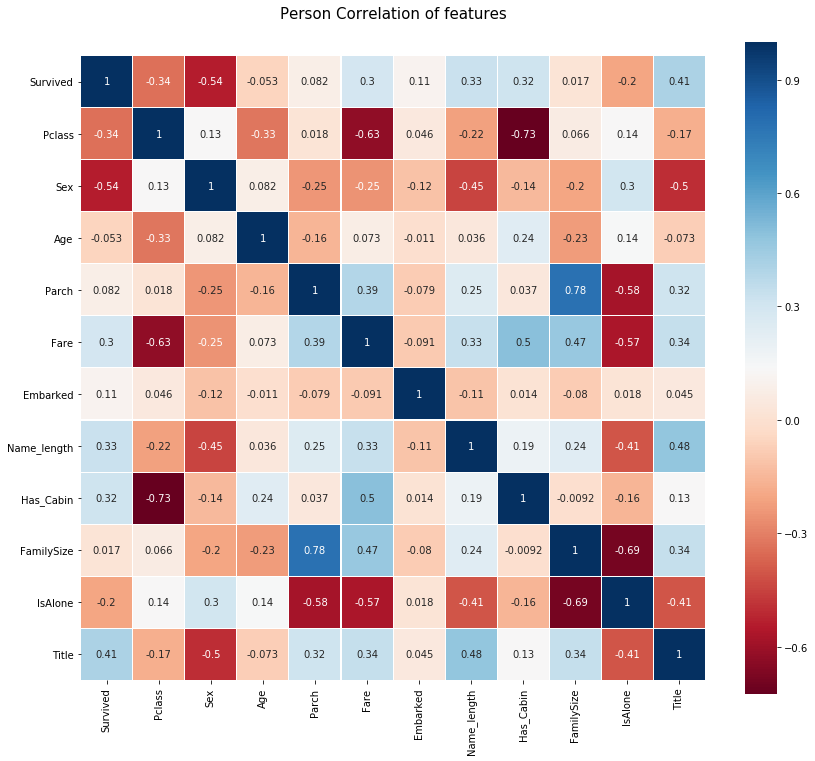

In [10]:
colormap = plt.cm.RdBu
y_position = 1.05
plt.figure(figsize = (14, 12))

plt.title("Person Correlation of features", y=y_position, size = 15)
sns.heatmap(train.astype(float).corr(), linewidth=0.1, vmax=1.0, square=True, cmap=colormap, linecolor="white", annot=True)

**Takeaway from the Plots**

One thing that the Person Correlation plot can tell us is that there are not too many features strongly correlated with one another. 

This is good from a point of view of feeding these features into your learning model because this means that there isn't much redundant of superfluous data in out training set and we are happy that each feature carries with it some unique information.

Here are two most correlated features are thart of Famil Size and Parch(Parents and Children).

FamilySize와 가장 연관이 있는 피처는 Parch(Parents and Children)이다. 

히트맵을 보면, 강한 상관관계를 갖는 피처들이 그렇게 많이 보이지 않는다는 점이다. ML모델을 학습하기에는 좋은 데이터의 분포라고 할수있다.(중복되는 피처가 적고, 학습세트에 과적합되는 사례가 줄어듬)


**Pairplots**

Pairplots는 한 피처와 다른 피처와의 데이터 분포도를 확인하는 것

[PairPlot Document](https://seaborn.pydata.org/generated/seaborn.pairplot.html?highlight=pairplot#seaborn.pairplot)

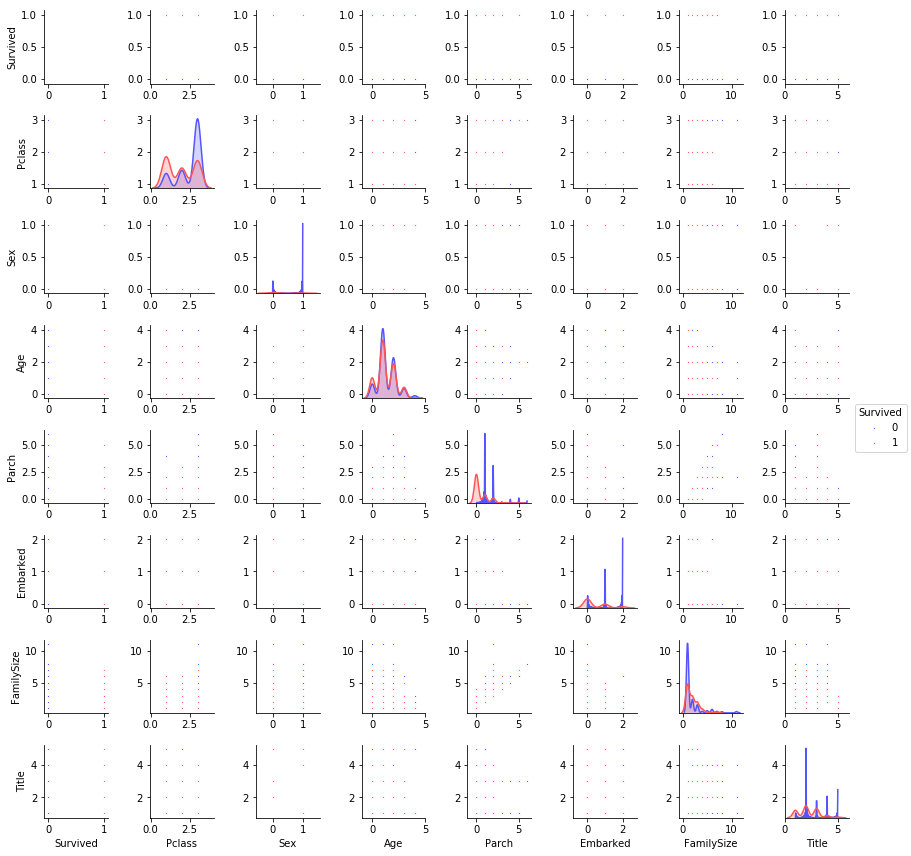

In [11]:
data = train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Embarked', u'FamilySize', u'Title']]
g = sns.pairplot(data = data, hue="Survived", palette="seismic", size = 1.5, diag_kind="kde", diag_kws=dict(shade=True), plot_kws=dict(s=5))
#g.set(xticklabels=[])

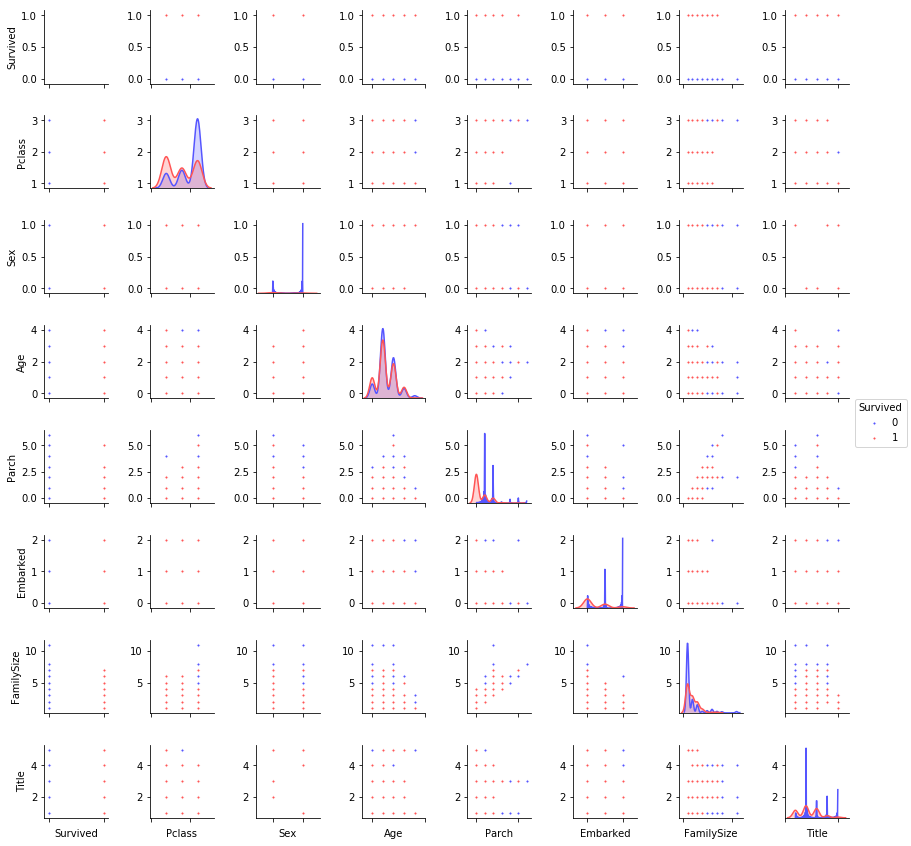

In [12]:
data  =train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Embarked', u'FamilySize', u'Title']]
g = sns.pairplot(data = data, hue='Survived', palette='seismic', size = 1.5, diag_kind='kde', diag_kws=dict(shade=True), plot_kws=dict(s=10))
g.set(xticklabels=[])  # X축의 눈금 스케일을 보여주지 않는군

# 앙상블 및 스태킹 모델

* 스태킹 앙상블 모델 

### Helpers via Python Classes

sklearnHelper클래스를 생성하여 학습 및 예측을 수행하는 메소드 생성

In [13]:
version = sklearn.__version__
versionChk = True

ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0
NFOLDS = 5

if version.split(".")[1] == "20":
    from sklearn.model_selection import KFold # 0.20 Use this API
    kf = KFold(n_splits = NFOLDS, random_state=SEED)
else:
    from sklearn.cross_validation import KFold # 0.18 will be removed
    kf = KFold(n_train, n_folds = NFOLDS, random_state = SEED)
    versionChk = False
display(ntrain, ntest)

891

418

**사이킷런의 객체를 상속받아 학습및 예측 객체 생성**

In [14]:
class SklearnHelper(object):
    """
    사이킷런의 객체를 상속받고, 사이킷런에서 제공하는 메소드를 구현하여 
    학습, 예측, 피처 중요도 구현
    """
    def __init__(self, clf, seed, params):
        params["random_state"] = seed
        self.clf = clf(**params)
        
    def get_name(self):
        return self.clf.__class__.__name__
    
    def train(self, X_train, y_train):
        self.clf.fit(X_train, y_train)
        
    def predict(self, X):
        """
        인자 - 테스트세트
        """
        return self.clf.predict(X)
    
    def feature_importance(self, X, y):
        """
        피처의 중요도를 출력
        X - 피처 데이터
        y - 레이블 데이터 
        """
        model = self.clf
        model.fit(X, y)
        display(model.feature_importances_)
        return model.feature_importances_

### Out-of-Fold Predictions

학습 세트에만 최적화되는 오버피팅을 방지하기 위한 OOF Predict구현

In [15]:
def loop_get_oof(clfs, X_train, y_train, X_test):
    """
    Out Of Fold Prediction를 모델의 갯수만큼 반복 수행
    """
    result = dict()
    
    for clf in clfs:
        display(clf.get_name())
        oof_train,oof_test = get_oof(clf, X_train, y_train, X_test)
        result[clf] = (oof_train, oof_test)
    return result

**[ML OOF Prediciton](https://techblog-history-younghunjo1.tistory.com/142)**

In [16]:
oof_train = np.zeros((891,))
display('oof_train  :', oof_train.shape)

oof_test  = np.zeros((481, ))
display('oof_test  :', oof_test.shape)

oof_test_skf = np.empty((5, 481))
display('oof_test_skf  :', oof_test_skf.shape, oof_test_skf)

'oof_train  :'

(891,)

'oof_test  :'

(481,)

'oof_test_skf  :'

(5, 481)

array([[  4.04738577e-320,   2.17388884e-321,   0.00000000e+000, ...,
          1.80664124e+217,   4.39554125e+257,   2.47885710e-056],
       [  1.71339615e-046,   1.39524223e+045,   1.22487779e+165, ...,
          3.31113415e-047,   1.73012977e-066,   6.30567275e+275],
       [  6.62023103e+025,   1.26926295e+059,   5.25363127e+122, ...,
          1.02129271e-041,   8.45273184e+281,   4.32394222e+271],
       [  3.05099310e+035,   3.94439116e+252,   7.37564282e+011, ...,
          7.97574337e+035,   4.15795766e+203,   5.00083822e+107],
       [  2.79330544e+276,   6.40077176e+020,   2.10667566e-099, ...,
          1.15165398e+021,   2.61565507e+029,   3.29473044e+074]])

In [17]:
def get_oof(clf, X_train, y_train, X_test):
    """
    OOF Prediction
    """
    oof_train = np.zeros((ntrain, )) # 891
    oof_test  = np.zeros((ntest,))   # 418
    oof_test_skf = np.empty((NFOLDS, ntest))
    
    # scikitlearn버전 0.18과 0.20버전에서 지원하는 API가 처리방식이 다름
    for i, (train_index, test_index) in enumerate(kf.split(X_train,y_train) if versionChk else kf):
        X_tr = X_train[train_index]
        y_tr = y_train[train_index]
        X_te = X_train[test_index]
        
        clf.train(X_tr, y_tr)
        
        # 검증폴드를 이용해 예측한 결과를 학습데이터로 생성
        oof_train[test_index] = clf.predict(X_te)
        
        # 테스트 데이터세트를 이용해 예측한 결과를 테스트데이터로생성
        oof_test_skf[i,:] = clf.predict(X_test)
        
    oof_test[:] = oof_test_skf.mean(axis = 0) #최종 평균값을 OOF테스트 데이터로 생성
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

# Generating our Base First-Level Models 

먼저 앙상블의 첫번째 단계로 5개의 ML모델을 대상으로 한다.

 1. Random Forest classifier
 2. Extra Trees classifier
 3. AdaBoost classifer
 4. Gradient Boosting classifer
 5. Support Vector Machine

**Parameters**

**n_jobs** : 학습시에 사용할 CPU코어 수.  -1의 의미는 모든 CPU코아를 다 사용

**n_estimators** : ML모델 분류기의 수 ( 디폴트는 10)

**max_depth** : 트리의 최대 깊이 수(크게 설정될수록 오버피팅이 위험이 존재함을 유념)

**verbose** : 학습이 진행될 동안 출력결과를 보고 싶을 경우 설정( 0 - 결과를 보이지 않음, 1- 결과보기)

In [18]:
#hyper parameter for RandomForestClassifier
rf_params = {
    "n_jobs": -1,
    "n_estimators":500,
    "warm_start": True,  # 객체 생성한 것을 재사용,
    #"max_feature":0.2,
    "max_depth":6,
    "min_samples_leaf": 2,
    "max_features": "sqrt",
    "verbose": 0
}

# hyper parameter for ExtraTreeClassifier
ext_params = {
    "n_jobs": -1,
    "n_estimators": 500,
    #"max_features": 0.2,
    "max_depth": 6,
    "min_samples_leaf": 2,
    "max_features": "sqrt",
    "verbose": True
}

#hyper parameter for AdaBoostClassifer
ada_params = {
    "n_estimators": 500,
    "learning_rate": 0.75
}

#hyper parameter for GradientBoost
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# hyper parameter for SVC
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
}

In [19]:
# Create 5 objects that represent our 4 models
rf = SklearnHelper(clf = RandomForestClassifier, seed = SEED, params = rf_params)
et = SklearnHelper(clf = ExtraTreesClassifier, seed = SEED, params = ext_params)
ada = SklearnHelper(clf = AdaBoostClassifier, seed = SEED, params = ada_params)
gb  = SklearnHelper(clf = GradientBoostingClassifier, seed = SEED, params = gb_params)
svm = SklearnHelper(clf = SVC, seed = SEED, params = svc_params)

**Creating NumPy arrays out of our train and test sets**

학습 및 테스트 세트로 부터 모델을 학습시킬 데이터세트 생성

In [20]:
# Create Numpy arrays of train, test and target ( Survived) dataframes to feed into our models
y_train = train["Survived"].ravel() # ravel()으로 pd.Series타입으로 1차원 ndarray타입으로 변환, 타겟값을 1차원배열로 ML모델에 학습시 이렇게 들어감
train = train.drop(["Survived"], axis=1, errors='ignore')

# ML모델을 학습시키기 위해서는 ndarray로 변환이 필요
X_train = train.values  #  DataFrame을 ndarray로 변환  - (891, 11)   
X_test  = test.values   #  DataFrame를 ndarray로 변환  - (481, 11)

**Output of the First level Predictions** 

학습 및 테스트 데이터를 5개의 ML모델을 학습시키고, OOF Prediction을 수행

In [21]:
# Create our OOF train and test predictions. These base results will be used as new features
clfs = [rf, et, ada, gb, svm]
result = loop_get_oof(clfs, X_train, y_train, X_test)

'RandomForestClassifier'

'ExtraTreesClassifier'

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapse

'AdaBoostClassifier'

'GradientBoostingClassifier'

'SVC'

**결과를 담고있는 변수에서 최종학습 및 테스트데이터셋 추출**

In [22]:
for k, v in result.items():
    clf_name = k.clf.__class__.__name__
    if clf_name =="RandomForestClassifier":
        print("OOF Train : ", v[0][1:5])
        print("OOF Test : ", v[1][1: 5])

OOF Train :  [[ 1.]
 [ 0.]
 [ 1.]
 [ 0.]]
OOF Test :  [[ 1.]
 [ 0.]
 [ 0.]
 [ 1.]]


In [23]:
def get_oof_train_test(clf):
    """
    OOF결과 리턴 받은 결과값에서 필요로 하는 분류기의 최종 학습 및 테스트 데이터세트 
    결과 가져오기
    """
    r0 = [v[0] for k, v in result.items() if k.clf.__class__.__name__ == clf]
    r1 = [v[1] for k, v in result.items() if k.clf.__class__.__name__ == clf]
    
    return r0, r1  

**각각의 분류기에 대한 학습 및 테스트 결과값**

In [24]:
rf_oof_train, rf_oof_test = get_oof_train_test('RandomForestClassifier')
et_oof_train, et_oof_test = get_oof_train_test('ExtraTreesClassifier')
ada_oof_train, ada_oof_test = get_oof_train_test('AdaBoostClassifier')
gb_oof_train, gb_oof_test = get_oof_train_test('GradientBoostingClassifier')
svm_oof_train, svm_oof_test = get_oof_train_test('SVC')

**Feature importances generated from the different classifiers**

* feature_importances_를 통해서 피처의 중요도 보기

In [25]:
rf_feature = rf.feature_importance(X_train, y_train)
et_feature = et.feature_importance(X_train, y_train)
ada_feature = ada.feature_importance(X_train, y_train)
gb_feature = gb.feature_importance(X_train, y_train)

array([ 0.12522177,  0.19798888,  0.03022962,  0.02109786,  0.0720267 ,
        0.02324097,  0.10864929,  0.06545899,  0.0676153 ,  0.01360018,
        0.27487044])

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.6s finished


array([ 0.11683491,  0.41546949,  0.01944531,  0.01344735,  0.04891303,
        0.02165059,  0.03542929,  0.09294054,  0.03525167,  0.02186699,
        0.17875084])

array([ 0.03 ,  0.008,  0.016,  0.066,  0.04 ,  0.01 ,  0.69 ,  0.014,
        0.052,  0.006,  0.068])

array([ 0.07822052,  0.026892  ,  0.11303381,  0.03277065,  0.0903747 ,
        0.05030455,  0.41629782,  0.02100433,  0.07182882,  0.02014478,
        0.07912803])

In [26]:
rf_feature = rf.clf.feature_importances_
et_feature = et.clf.feature_importances_
ada_feature = ada.clf.feature_importances_
gb_feature = gb.clf.feature_importances_

* 위의 결과값을 변수에 할당 - 위의 형태로 바로 클래스객체 바로 호출해봄.

In [27]:
rf_feature, et_feature, ada_feature, gb_feature

(array([ 0.12522177,  0.19798888,  0.03022962,  0.02109786,  0.0720267 ,
         0.02324097,  0.10864929,  0.06545899,  0.0676153 ,  0.01360018,
         0.27487044]),
 array([ 0.11683491,  0.41546949,  0.01944531,  0.01344735,  0.04891303,
         0.02165059,  0.03542929,  0.09294054,  0.03525167,  0.02186699,
         0.17875084]),
 array([ 0.03 ,  0.008,  0.016,  0.066,  0.04 ,  0.01 ,  0.69 ,  0.014,
         0.052,  0.006,  0.068]),
 array([ 0.07822052,  0.026892  ,  0.11303381,  0.03277065,  0.0903747 ,
         0.05030455,  0.41629782,  0.02100433,  0.07182882,  0.02014478,
         0.07912803]))

**피처 중요도를 DataFrame형태로 생성**

In [28]:
cols = train.columns.values
data = {
    "feature": cols, 
    "Ranfom Forest Feature Importances": rf_feature,
    "Extra Tree Feature Imortances": et_feature,
    "AdaBoost Feature Importances": ada_feature,
    "Gradient Boost Feature Imortances": gb_feature
}

feature_dataframe = pd.DataFrame(data)
display(feature_dataframe)

,feature,Ranfom Forest Feature Importances,Extra Tree Feature Imortances,AdaBoost Feature Importances,Gradient Boost Feature Imortances
0,Pclass,0.125222,0.116835,0.030,0.078221
1,Sex,0.197989,0.415469,0.008,0.026892
2,Age,0.030230,0.019445,0.016,0.113034
3,Parch,0.021098,0.013447,0.066,0.032771
4,Fare,0.072027,0.048913,0.040,0.090375
5,Embarked,0.023241,0.021651,0.010,0.050305
6,Name_length,0.108649,0.035429,0.690,0.416298
7,Has_Cabin,0.065459,0.092941,0.014,0.021004
8,FamilySize,0.067615,0.035252,0.052,0.071829
9,IsAlone,0.013600,0.021867,0.006,0.020145


In [29]:
feature_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 5 columns):
feature                              11 non-null object
Ranfom Forest Feature Importances    11 non-null float64
Extra Tree Feature Imortances        11 non-null float64
AdaBoost Feature Importances         11 non-null float64
Gradient Boost Feature Imortances    11 non-null float64
dtypes: float64(4), object(1)
memory usage: 520.0+ bytes


**Interactive feature importances via Plotly scatterplots**

* Potly를 이용해 Scatter그리기
* [plotly tutorial for Python](https://plotly.com/python/)

* Scatter Plot using Plotly

In [30]:
# 분류기별로 피처 중요도를 그리기위함
# ['Ranfom Forest Feature Importances','Extra Tree Feature Imortances', 'AdaBoost Feature Importances', 'Gradient Boost Feature Imortances']
cols = feature_dataframe.columns.values[1:].tolist()

for col in cols:
    trace = go.Scatter(
        y = feature_dataframe[col].values,
        x = feature_dataframe["feature"].values,
        mode = "markers",
        marker = dict(
            sizemode="diameter",
            sizeref = 1,
            size = 25,
            #       size= feature_dataframe['AdaBoost feature importances'].values,
            #color = np.random.randn(500), #set color equal to a variable
            color = feature_dataframe[col].values,
            colorscale="Portland",
            showscale=True
        ),
        text = feature_dataframe["feature"].values
    )
    data = [trace]
    layout  = go.Layout(autosize = True, title = col, hovermode='closest', 
                        #     xaxis= dict(
                        #         title= 'Pop',
                        #         ticklen= 5,
                        #         zeroline= False,
                        #         gridwidth= 2,
                        #     ),
                        yaxis = dict(
                            title="Feature Importances",
                            ticklen =5,
                            gridwidth=2
                        ),
                        showlegend = False
                       )
    fig = go.Figure(data = data , layout=layout)
    py.iplot(fig, filename="Scatter2010")

* Feature Importance값의 평균값을 새로운 피처로 생성

In [31]:
feature_dataframe["mean"] = feature_dataframe.mean(axis = 1)
feature_dataframe.head()

,feature,Ranfom Forest Feature Importances,Extra Tree Feature Imortances,AdaBoost Feature Importances,Gradient Boost Feature Imortances,mean
0,Pclass,0.125222,0.116835,0.030,0.078221,0.087569
1,Sex,0.197989,0.415469,0.008,0.026892,0.162088
2,Age,0.030230,0.019445,0.016,0.113034,0.044677
3,Parch,0.021098,0.013447,0.066,0.032771,0.033329
4,Fare,0.072027,0.048913,0.040,0.090375,0.062829


**Plotly Barplot of Average Feature Importances**

피처 중요도의 평균을 바차트로 표시

In [32]:
y = feature_dataframe["mean"].values # 분류기별 피처중요도의 평균값
x = feature_dataframe["feature"].values # 피처명

# data region
data = [
    go.Bar(
        x = x,
        y = y,
        marker = dict(
            color=feature_dataframe["mean"].values,
            colorscale="Portland",
            showscale=True,
            reversescale=False  # False이면 피처중요도가 높은 피처가 색깔이 밝은 색 계열로 시작, True이면 이와 반대임
        ),
        opacity=0.6
    )
]

#그래프의 배치 및 눈금 
layout = go.Layout(
    autosize=True,
    title = "BarPlot of Mean Feature Importance",
    hovermode="Closest",
    #xaxis=dict(
     #   title="Feature Mean",
     #   ticklen=5,
     #   zeroline=False,
     #   gridwidth=2
    #),
    yaxis=dict(
        title="Feature Importances",
        ticklen=5,
        gridwidth=2        
    ),
    showlegend=False
)

fig = go.Figure(data = data, layout=layout)
py.iplot(fig, filename="barplot_featureimportance")

# Second-Level Predictions from the First-level Output

**First-level output as new features**

In [33]:
display(type(rf_oof_train[0]))
display(rf_oof_train[0].shape)

numpy.ndarray

(891, 1)

In [34]:
data = {
        "RandomForest": rf_oof_train[0].ravel(),"ExtraTrees": et_oof_train[0].ravel(),"AdaBoost": ada_oof_train[0].ravel(),"GradientBoost": gb_oof_train[0].ravel()
    }
base_predicitons_train = pd.DataFrame(data)
base_predicitons_train.head()

,RandomForest,ExtraTrees,AdaBoost,GradientBoost
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,0.0,0.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


** Correlation Heatmap of the Second Level Training set**

In [35]:
data = [
    go.Heatmap(
        z = base_predicitons_train.astype(float).corr().values,
        x = base_predicitons_train.columns.values,
        y = base_predicitons_train.columns.values,
        colorscale="Viridis",
        showscale=True,
        reversescale=True  # 색깔이 밝을수록 피처의 영향도는 적음을 의미
    )
]
py.iplot(data, filename="labelled-heatmap")

In [36]:
# 리턴한 한 타입이 리스트안에 배열로 들어가있으니까...ndarray타입으로 해야 하니 인덱스 [0]을 취한 것.
X_train = np.concatenate((et_oof_train[0], rf_oof_train[0], ada_oof_train[0], gb_oof_train[0], svm_oof_train[0]), axis = 1)
X_test  = np.concatenate((et_oof_test[0], rf_oof_test[0], ada_oof_test[0], gb_oof_test[0], svm_oof_test[0]), axis= 1)

1차 base estimator에서 나온 학습 및 테스트 세트를 병합해 메타 머신 러닝 모델에서 사용

### XGBoost를 이용한 메타모델 학습 및 예측

XGBoost를 최종 메타모델 분류기로 사용 할 것이고 자세한 내용은 공식 사이트를 참조하기 바랍니다.

[official Documentation][1].

  [1]: https://xgboost.readthedocs.io/en/latest/

In [37]:
gbm = XGBClassifier(n_estimators=2000,
                   learning_rate=0.02,
                   max_depth=4,
                   min_child_weight=2,
                   gamma=0.9,
                   subsample=0.8,
                   colspample_bytree=0.8,
                   objective="binary:logistic",
                   nthreads=-1,
                   scale_pos_weight=1)
gbm.fit(X_train, y_train)
predictions = gbm.predict(X_test)

XGBoost 대표적인 파라미터:

**max_depth** : 트리의 깊이 제어(related to the machine learning model overfitting)

**gamma** : 오버피팅을 위한 제어값

**eta** : learning_rate와 유사하다고 보면 됨

**최종 결과 제출 파일**

In [38]:
StackingSubmission = pd.DataFrame(
    {
                "PassengerId": PassengerId,
                "Survived": predictions
    }
)
display(StackingSubmission.head(n=3))

,PassengerId,Survived
0,892,0
1,893,1
2,894,0


In [39]:
StackingSubmission.to_csv(target_dir + "StackingSubmission.csv", index = False)

### 결론

스태킹 및 앙상블 기법에 대한 좋은 자료 참조 

website MLWave: [Kaggle Ensembling Guide][1]. 

[1]: http://mlwave.com/kaggle-ensembling-guide/